# Geodesics on Learned Manifolds

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap

import haiku as hk

import torchvision.utils as vutils

#numpy
import numpy as np

from abc import ABC

import torch

import matplotlib.pyplot as plt

from geodesics import GradientDescent, JAXOptimization, ScipyOptimization, GC_LineSearch

from load_manifold import load_manifold
from vae.model_loader import mnist_generator, svhn_generator, celeba_generator, load_model

from vae.models import mnist_encoder
from vae.models import mnist_decoder
from vae.models import mnist_vae

from vae.models import svhn_encoder
from vae.models import svhn_decoder
from vae.models import svhn_vae

from vae.models import celeba_encoder
from vae.models import celeba_decoder
from vae.models import celeba_vae

2024-06-04 20:58:31.020840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
seed = 2712
model_path = 'models/'

## VAE MNIST

In [3]:
z0, zT, M, vae_fun = load_manifold("mnist")

2024-06-04 20:58:32.457321: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-06-04 20:58:33.820365: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Loading Data

In [3]:
mnist_dataloader = mnist_generator(seed=2712,
                                   batch_size=64,
                                   split='train[:80%]')

2024-06-04 14:40:49.761837: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Loading Model

In [4]:
@hk.transform_with_state
def mnist_tvae(x):


    vae = mnist_vae(
                encoder=mnist_encoder(latent_dim=8, is_training=True),
                decoder=mnist_decoder(is_training=True),
    )

    return vae(x)

@hk.transform_with_state
def mnist_tencoder(x):


    encoder = mnist_encoder(latent_dim=8, is_training=True)

    return encoder(x)[0]

@hk.transform_with_state
def mnist_tdecoder(x):

    decoder = mnist_decoder(is_training=True)

    return decoder(x)

In [5]:
mnist_state = load_model(''.join((model_path, 'mnist/')))

In [6]:
mnist_encoder_fun = lambda x: mnist_tencoder.apply(mnist_state.params, mnist_state.state_val,None, x.reshape(-1,28,28,1))[0].reshape(-1,8).squeeze()
mnist_decoder_fun = lambda x: mnist_tdecoder.apply(mnist_state.params, mnist_state.state_val, None, x.reshape(-1,8)).reshape(-1,28*28).squeeze()
mnist_vae_fun = lambda x: mnist_tvae.apply(mnist_state.params, mnist_state.state_val, mnist_state.rng_key, x)[0]

In [ ]:
from typing import NamedTuple
import optax
from jax import Array

class TrainingState(NamedTuple):
    params: hk.Params
    state_val:  dict
    opt_state: optax.OptState
    rng_key: Array

class test_class(object):
    def __init__(self, state):
        
        self.state = state
        
    def __call__(self, x):

        mnist_state = self.state
        out, state_val = mnist_tdecoder.apply(mnist_state.params, mnist_state.state_val, mnist_state.rng_key, x)
        
        self.state = TrainingState(mnist_state.params, state_val, mnist_state.opt_state, mnist_state.rng_key)
        
        return out
    
from jax import jacfwd
class test2_class(object):
    def __init__(self, state):
        
        self.state = state
        
    def __call__(self, x):

        val = test_class(self.state)
        
        return jacfwd(val)(x)
        

In [8]:
mnist_data = next(mnist_dataloader).x

In [9]:
test_fun = test2_class(mnist_state)
z = mnist_encoder_fun(mnist_data)

In [14]:
jacfwd(test_fun)(z[0].reshape(1,-1))

Array([[[[[[[[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]],

            ...,

            [[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]]]]],




         [[[[[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]],

            ...,

            [[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]]]]],




         [[[[[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]],

            ...,

            [[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0., 0.]]]]],




         ...,




         [[[[[0., 0., 0., ..., 0., 0., 0.]],

            [[0., 0., 0., ..., 0., 0

In [22]:
from jax import jacfwd
test_new = jacfwd(test_fun)

In [23]:
test_new(z).shape

(64, 28, 28, 1, 64, 8)

### Plotting Reconstruction

In [31]:
mnist_data = next(mnist_dataloader).x

In [32]:
mnist_rec = mnist_vae_fun(mnist_data)

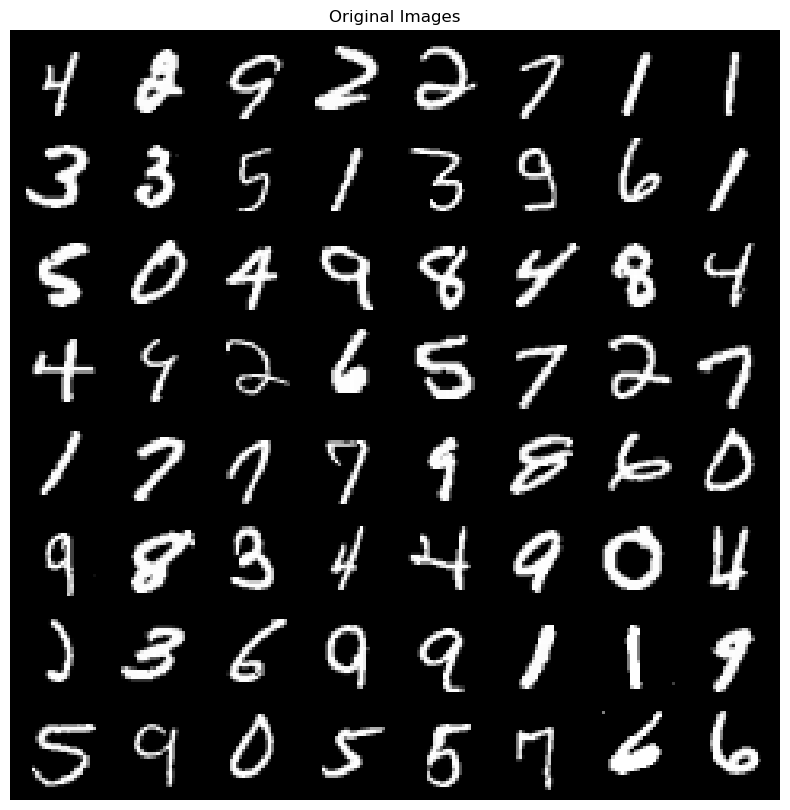

In [33]:
plot_val = torch.from_numpy(np.transpose(np.array(mnist_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

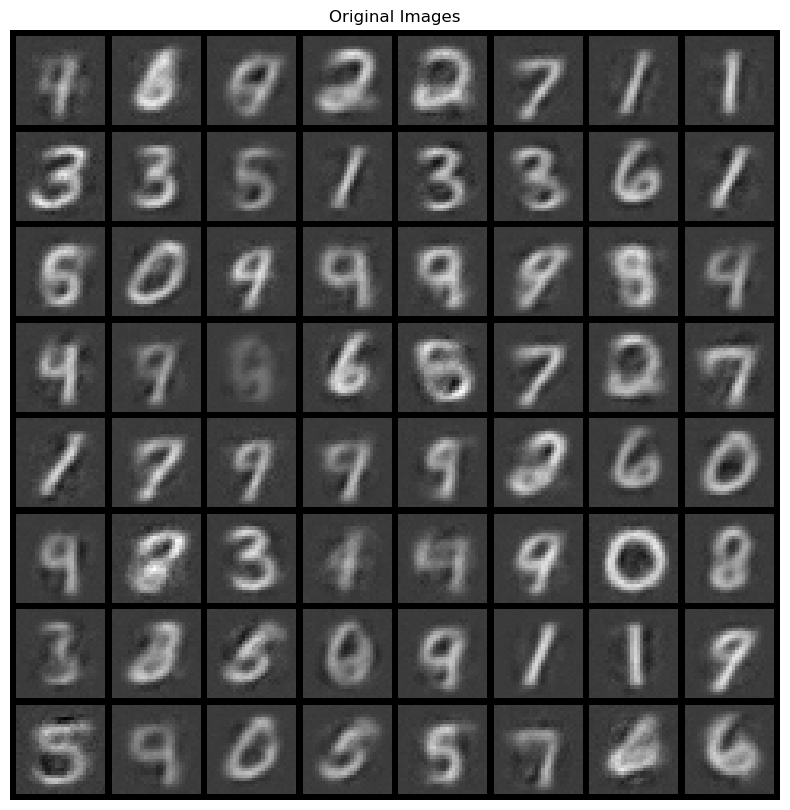

In [34]:
plot_val = torch.from_numpy(np.transpose(np.array(mnist_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

### Loading Model

In [14]:
from vae.models.train.mnist import Encoder as mnist_encoder_train
from vae.models.train.mnist import Decoder as mnist_decoder_train
from vae.models.train.mnist import VAE as mnist_vae_train

In [15]:
@hk.transform_with_state
def mnist_tvae(x):


    vae = mnist_vae_train(
                encoder=mnist_encoder_train(latent_dim=8),
                decoder=mnist_decoder_train(),
    )

    return vae(x, False)

@hk.transform_with_state
def mnist_tencoder(x):


    encoder = mnist_encoder_train(latent_dim=8)

    return encoder(x, False)[0]

@hk.transform_with_state
def mnist_tdecoder(x):

    decoder = mnist_decoder_train()

    return decoder(x, False)

In [16]:
mnist_state.params['encoder/~/batch_norm_1']

{'offset': array([[[[ 0.01003074,  0.00091037, -0.00883293,  0.01411654,
            0.00291514,  0.01238248, -0.00309094,  0.01033282,
            0.01105151,  0.0024682 ,  0.00663051,  0.01169875,
            0.02058273,  0.00420174,  0.00352465,  0.00326377,
            0.00612546,  0.01357205,  0.02355343,  0.00609909,
            0.01075974,  0.0078121 ,  0.0128788 ,  0.00804684,
           -0.00065186, -0.00045714,  0.01326703,  0.02016717,
            0.00416893, -0.00258093,  0.00519438,  0.00355915,
           -0.0106132 ,  0.01484156, -0.00179084,  0.02019798,
            0.01625353,  0.00660768, -0.01029849, -0.00795532,
            0.01757788,  0.00707004,  0.00382433,  0.01549061,
            0.00374154,  0.00315869,  0.00565448,  0.00225053,
           -0.00063028,  0.02885921,  0.00408642,  0.00133976,
            0.00013283,  0.00207875,  0.01241956,  0.01048419,
            0.01661967,  0.01559543,  0.00085925,  0.01691572,
            0.00265493,  0.01476597,  0.01800

In [17]:
mnist_state = load_model(''.join((model_path, 'mnist/')))

In [18]:
mnist_encoder_fun = lambda x: mnist_tencoder.apply(mnist_state.params, mnist_state.state_val, 
                                                   None, x.reshape(-1,28,28,1))[0].reshape(-1,8).squeeze()
mnist_decoder_fun = lambda x: mnist_tdecoder.apply(mnist_state.params, mnist_state.state_val,
                                                   None, x.reshape(-1,8))[0].reshape(-1,28*28).squeeze()
mnist_vae_fun = lambda x: mnist_tvae.apply(mnist_state.params, mnist_state.state_val,
                                           mnist_state.rng_key, x)[0]

In [19]:
test_mu_zx = mnist_encoder_fun(next(mnist_dataloader).x)

In [20]:
from jax import jacfwd
test_fun = jacfwd(mnist_decoder_fun)

In [21]:
test_fun(test_mu_zx[0])

Array([[ 0.43689942,  0.36749598, -0.27863628, ..., -0.06473991,
         0.13917662, -0.20366648],
       [-0.41388762, -0.1965898 , -0.7212214 , ..., -0.18015343,
        -0.03251356,  0.14852922],
       [-0.56206053, -0.1356825 , -0.7150912 , ...,  0.03315585,
         0.0535432 , -0.31013617],
       ...,
       [ 0.26770285,  0.15918267,  0.03972031, ..., -0.41901907,
         0.4931687 , -0.05099838],
       [-0.15402575, -0.27002794, -0.85749996, ...,  0.3774339 ,
        -0.1780841 , -0.04182552],
       [ 1.3790168 ,  1.9799421 ,  0.85853946, ..., -0.23963153,
        -0.16877419, -0.2639863 ]], dtype=float32)

### Plotting Reconstruction

In [22]:
mnist_data = next(mnist_dataloader).x

In [23]:
mnist_rec = mnist_vae_fun(mnist_data)

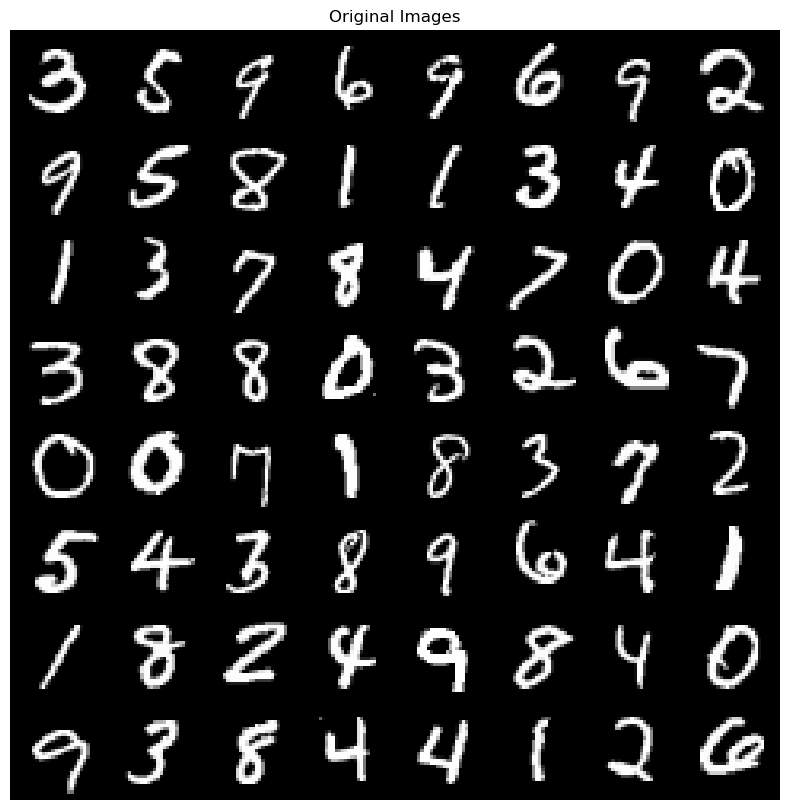

In [24]:
plot_val = torch.from_numpy(np.transpose(np.array(mnist_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

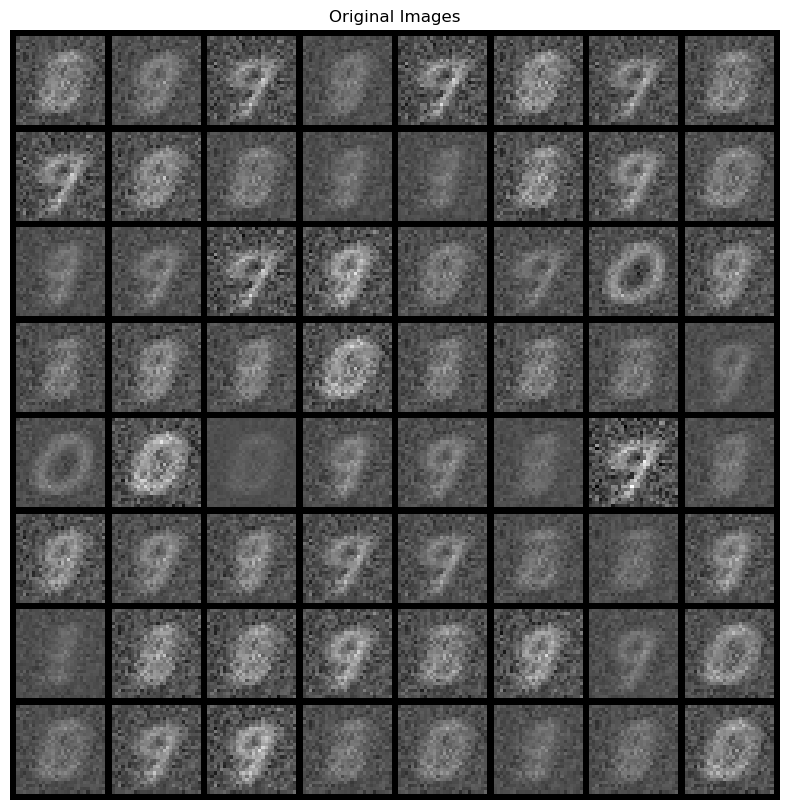

In [25]:
plot_val = torch.from_numpy(np.transpose(np.array(mnist_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

## VAE SVHN

### Loading Data

In [35]:
svhn_dataloader = svhn_generator(data_dir="../../../Data/SVHN/",
                                 batch_size=64,
                                 seed=2712,
                                 split='train[:80%]')

### Loading Model

In [36]:
@hk.transform_with_state
def svhn_tvae(x):


    vae = svhn_vae(
                encoder=svhn_encoder(latent_dim=32, is_training=True),
                decoder=svhn_decoder(is_training=True),
    )

    return vae(x)

@hk.transform_with_state
def svhn_tencoder(x):


    encoder = svhn_encoder(latent_dim=32, is_training=True)

    return encoder(x)

@hk.transform_with_state
def svhn_tdecoder(x):

    decoder = svhn_decoder(latent_dim=32, is_training=True)

    return decoder(x)

In [37]:
svhn_state = load_model(''.join((model_path, 'svhn/')))

In [38]:
svhn_encoder_fun = lambda x: svhn_tencoder.apply(svhn_state.params, svhn_state.state_val,svhn_state.rng_key, x)
svhn_decoder_fun = lambda x: svhn_tdecoder.apply(svhn_state.params, svhn_state.state_val,svhn_state.rng_key, x)
svhn_vae_fun = lambda x: svhn_tvae.apply(svhn_state.params, svhn_state.state_val,svhn_state.rng_key, x)

### Plotting Reconstruction

In [39]:
svhn_data = next(svhn_dataloader).x

In [40]:
svhn_rec, _ = svhn_vae_fun(svhn_data)

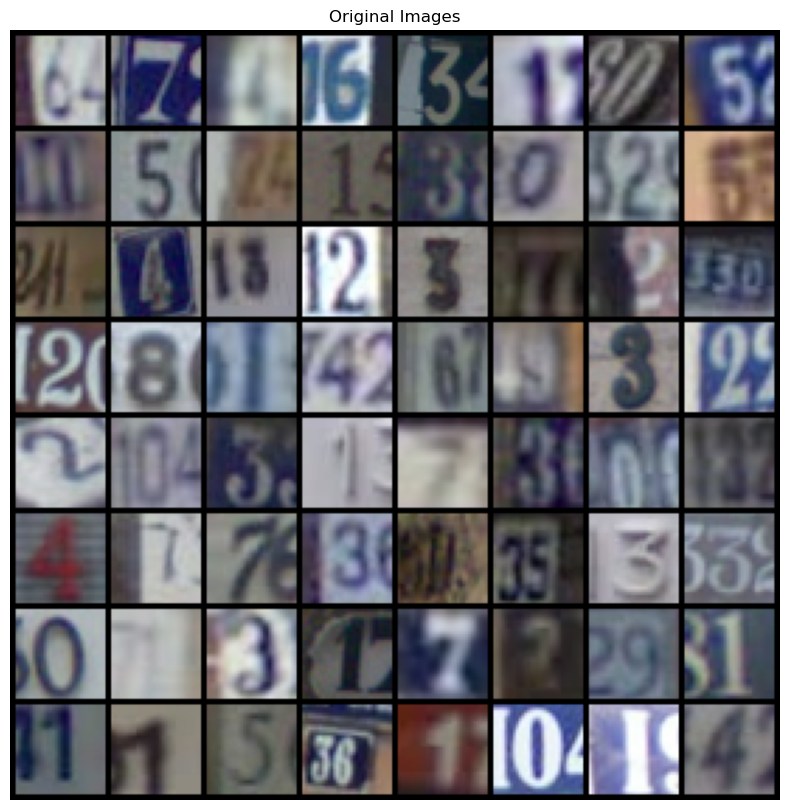

In [41]:
plot_val = torch.from_numpy(np.transpose(np.array(svhn_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

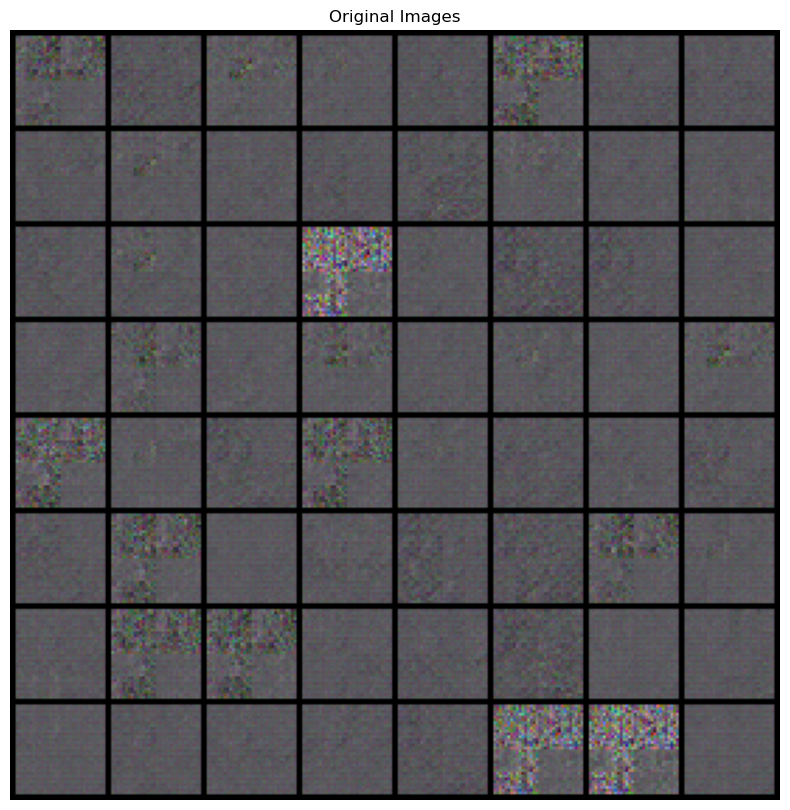

In [42]:
plot_val = torch.from_numpy(np.transpose(np.array(svhn_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

## VAE CelebA

### Loading Data

In [43]:
celeba_dataloader = celeba_generator(data_dir="../../../Data/CelebA/",
                                     batch_size=64,
                                     seed=2712, 
                                     split=0.8)

### Loading Model

In [44]:
@hk.transform_with_state
def celeba_tvae(x):


    vae = celeba_vae(
                encoder=celeba_encoder(latent_dim=32),
                decoder=celeba_decoder(),
    )

    return vae(x)

@hk.transform
def celeba_tencoder(x):


    encoder = celeba_encoder(latent_dim=32)

    return encoder(x)

@hk.transform
def celeba_tdecoder(x):

    decoder = celeba_decoder(latent_dim=32)

    return decoder(x)

In [45]:
celeba_state = load_model(''.join((model_path, 'celeba/')))

In [46]:
celeba_encoder_fun = lambda x: celeba_tencoder.apply(celeba_state.params, celeba_state.rng_key, x)
celeba_decoder_fun = lambda x: celeba_tdecoder.apply(celeba_state.params, celeba_state.rng_key, x)
celeba_vae_fun = lambda x: celeba_tvae.apply(celeba_state.params, celeba_state.rng_key, x)

### Plotting Reconstruction

In [47]:
celeba_data = next(celeba_dataloader).x

In [48]:
celeba_rec = celeba_vae_fun(celeba_data)

NonEmptyStateError: If your transformed function uses `hk.{get,set}_state` then use `hk.transform_with_state`.

In [ ]:
plot_val = torch.from_numpy(np.transpose(np.array(celeba_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
plot_val = torch.from_numpy(np.transpose(np.array(celeba_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))